In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os

sys.path.append('/home/user/deep-learning/')
sys.path.append('/home/gbaasch/projects/def-revins/gbaasch/deep-learning')
sys.path.append('../../methods')

In [3]:
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from fastai.metrics import root_mean_squared_error

import matplotlib.pyplot as plt
import pandas as pd

from BlackBoxMethod import ResNet, BasicBlock, RNNRegression
from BuildingDataset import BuildingDataset, DataBunch, get_dls

from training.exp.learner import Learner
from training.exp.runner import prep_run_vanilla, prep_one_cycle
# from datahandlers.exp.basic_databunch import DataBunch, get_dls

# Params for papermill

In [4]:
# this cell is tagged `parameters`
label_idx   = 5 
network     = 'cnn'
run_count   = 1
train_fname = '../../hdf5/train.hdf5'
valid_fname  = '../../hdf5/test.hdf5'

In [5]:
save_name = str(label_idx) + '_' + network + '_' + str(run_count)

In [6]:
label_idx, network, run_count, save_name

(5, 'cnn', 1, '5_cnn_1')

# Prep Data

In [7]:
# train_fname, valid_fname = 'train.hdf5', 'test.hdf5'
batch_size = 100

train_ds = BuildingDataset(train_fname, label_idx)
valid_ds = BuildingDataset(valid_fname, label_idx)

len(train_ds), len(valid_ds)

data = DataBunch(*get_dls(train_ds, valid_ds, batch_size))
data.train_ds[0][0].shape

torch.Size([2000, 4])

# Train

In [8]:
use_gpu = True

def run_model(model, opt, db, lr=0.01, epochs=10):
    # prepare basic training
    loss = F.mse_loss
    metrics = [root_mean_squared_error]
    learner = Learner(model, opt, db, loss, use_gpu=use_gpu)
    # run training loop
    run = prep_run_vanilla(metrics, use_cuda=use_gpu)
    run.fit(epochs, learner)
    run.recorder.plot_loss()
    return learner

def run_model_one_cycle(model, opt, db, epochs=10):
    # prepare basic training
    loss = F.mse_loss
    metrics = [root_mean_squared_error]
    learner = Learner(model, opt, db, loss, use_gpu=use_gpu)
    # run training loop
    run = prep_one_cycle(use_cuda=use_gpu, metrics=metrics, min_lr=0.00001, max_lr=0.001)
    run.fit(epochs, learner)
    run.recorder.plot_loss()
    return learner

In [9]:
def resnet(ni, **kwargs):
    model = ResNet(ni, BasicBlock, [3, 4, 6, 3, 3], **kwargs)
    return model

In [10]:
if network == 'cnn':
    model = resnet(ni=4, num_classes=1)
    
elif network == 'rnn':
    model = RNNRegression(ni=4)
    
opt = torch.optim.Adam(model.parameters())

epoch      train loss          valid loss     root_mean_squared_error
0          8601.2976           7082.0911            79.5166       


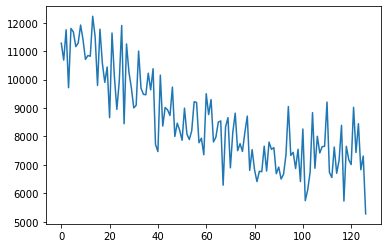

In [11]:
learner = run_model_one_cycle(model, opt, data, epochs=200)

# Predict

In [12]:
# mpath = f'models/cnn_inf' 
mpath = os.path.join('models', save_name)

In [13]:
torch.save(model.state_dict(), mpath) 

In [14]:
state = torch.load(mpath)
if network == 'cnn':
    m = resnet(ni=4, num_classes=1)
    
elif network == 'rnn':
    m = RNNRegression(ni=4)

ml = m.cuda()
ml.load_state_dict(state)
ml.eval();

In [15]:
del model
torch.cuda.empty_cache()

In [16]:
valid_preds = ml(data.valid_dl.x.cuda()) 

### Predict Train

In [17]:
# plt.scatter(data.train_dl.y, train_preds.tolist());
# plt.plot(data.train_dl.y, data.train_dl.y);
# plt.grid()

### Predict Valid

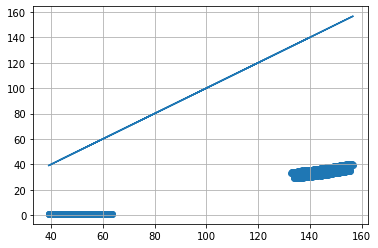

In [18]:
plt.scatter(data.valid_dl.y, valid_preds.tolist());
plt.plot(data.valid_dl.y, data.valid_dl.y);
plt.grid()

# Predict each case

In [19]:
cases_no_infiltration = [
    ('victoria', 'control_concrete', 'False'),
    ('victoria', 'control_concrete', 'True'),
    ('victoria', 'control_wood', 'False'),
    ('victoria', 'control_wood', 'True'),
    ('chicago', 'control_concrete', 'False'),
    ('chicago', 'control_concrete', 'True'),
    ('chicago', 'control_wood', 'False'),
    ('chicago', 'control_wood', 'True'),
    ('victoria', 'control_concrete_inf', 'False'),
    ('victoria', 'control_concrete_inf', 'True'),
    ('victoria', 'control_wood_inf', 'False'),
    ('victoria', 'control_wood_inf', 'True'),
    ('chicago', 'control_concrete_inf', 'False'),
    ('chicago', 'control_concrete_inf', 'True'),
    ('chicago', 'control_wood_inf', 'False'),
    ('chicago', 'control_wood_inf', 'True')
]

In [20]:
def case_string(case):
    case_name = ''
    for c in case:
        case_name += c #+ '\n'
    return case_name

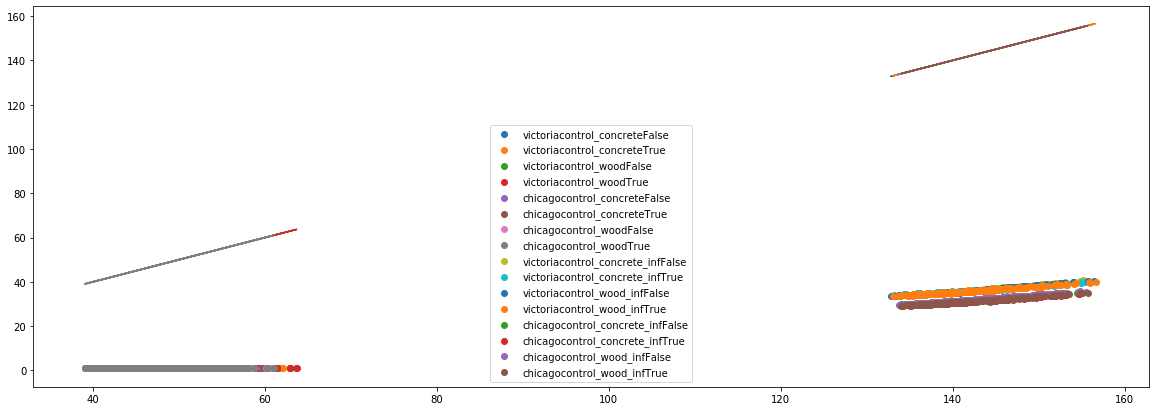

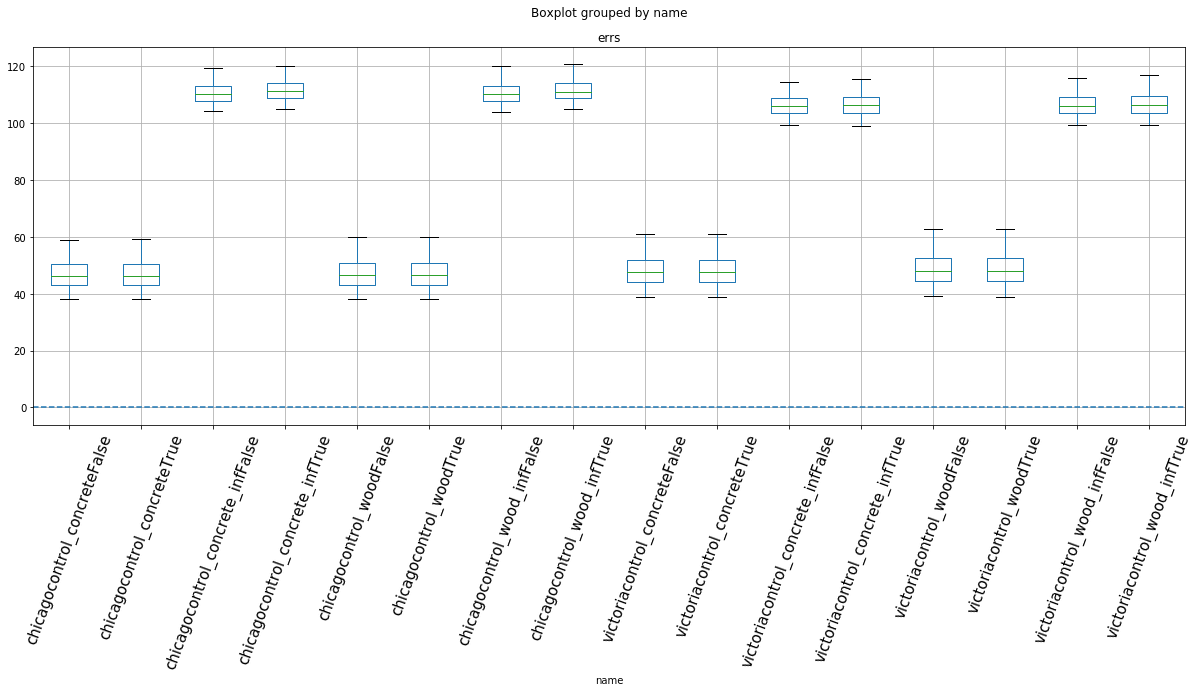

In [21]:
df_errs_all = pd.DataFrame()

plt.figure(figsize=(20,7))

for case in cases_no_infiltration:
    x, y = data.valid_dl.get_by_metadata(list(case))
    preds = ml(x.cuda()) 
    case_name = case_string(case)
    plt.scatter(y, preds.tolist(), label=case_name);
    plt.plot(y, y);
    plt.grid()
#     plt.show()
    df_errors = pd.DataFrame()
    df_errors['errs'] = y.sub(preds.to("cpu")).tolist()
    df_errors['name'] = case_name
    df_errs_all = df_errs_all.append(df_errors)
plt.legend()
plt.show()  

df_errs_all.boxplot(column='errs', by='name', figsize=(20, 7))
plt.axhline(0, 0, 1, label='No Error', linestyle='--')
plt.xticks(rotation=70, fontsize=15);